# 12. SOFR Yield Curve Construction

In [1]:
from fixedincome2025 import table

## Overview

* The SOFR yield curve is by far the most important curve if you work in a bank's rates business
    * Most OTC products, e.g. swaps, use SOFR as the index rate
* In this chapter, we study the SOFR yield curve construction
    * As we will see now, it is very different from Treasury yield curve construction


## Curve Instruments

* Unlike Treasury yield curve which is constructed from the Treasuries, there is no SOFR bonds
* The SOFR yield curve is constructed from futures and swaps, as they are the most liquid rates instruments linked to the SOFR index

In [25]:
table('key_dates')

,Integer Year Fraction,IMM Dates,FOMC Meeting Dates,From Prev Key Date (Days),From Today (Days),Year Fraction
,,9/17/2025,9/17/2025,0,-42,-0.1151
,,,10/29/2025,42,-16,-0.0438
,11/14/2025,,,16,0,0.0000
,,,12/10/2025,26,26,0.0712
,,12/17/2025,,7,33,0.0904
,,,1/28/2026,42,75,0.2055
,,3/18/2026,3/18/2026,49,124,0.3397
,,,4/29/2026,42,166,0.4548
,,6/17/2026,6/17/2026,49,215,0.5890
,,,7/29/2026,42,257,0.7041


In [24]:
import numpy as np
import datetime

df = table('key_dates').iloc[:, :3]
diff = np.diff(sorted([datetime.datetime.strptime(date_str, '%m/%d/%Y') for date_str in np.unique(df.values.flatten()) if date_str != ' ']))
[(td.days-58)/365 for td in diff.cumsum()]

[-0.043835616438356165,
 0.0,
 0.07123287671232877,
 0.09041095890410959,
 0.2054794520547945,
 0.33972602739726027,
 0.4547945205479452,
 0.589041095890411,
 0.7041095890410959,
 0.8383561643835616,
 0.9534246575342465,
 1.0,
 1.0684931506849316,
 1.0876712328767124]

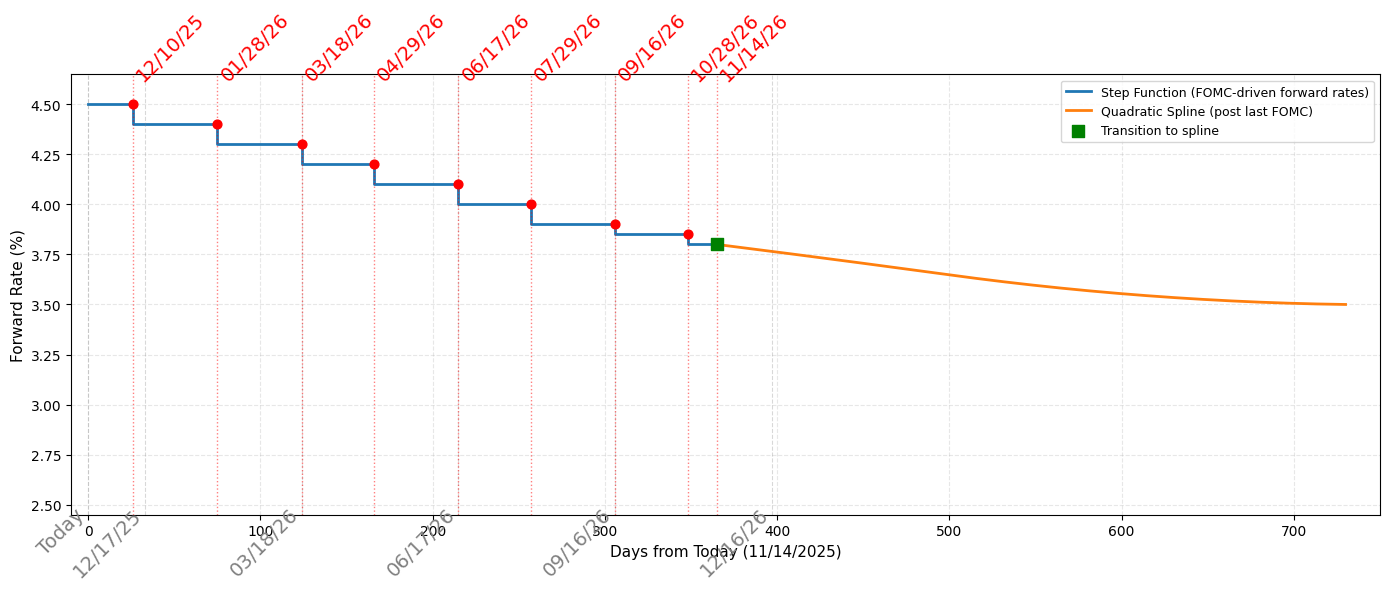

In [14]:
# SOFR Yield Curve Construction Timeline: Step Function → Quadratic Spline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.interpolate import interp1d

# Define key dates
today = datetime(2025, 11, 14)
imm_dates = [
    datetime(2025, 12, 17),
    datetime(2026, 3, 18),
    datetime(2026, 6, 17),
    datetime(2026, 9, 16),
    datetime(2026, 12, 16)
]

fomc_dates = [
    datetime(2025, 12, 10),
    datetime(2026, 1, 28),
    datetime(2026, 3, 18),
    datetime(2026, 4, 29),
    datetime(2026, 6, 17),
    datetime(2026, 7, 29),
    datetime(2026, 9, 16),
    datetime(2026, 10, 28),
    datetime(2026, 11, 14)
]

# Convert to days from today for plotting
def to_days(dt):
    return (dt - today).days

timeline_dates = [today] + imm_dates
timeline_days = [to_days(d) for d in timeline_dates]
fomc_days = [to_days(d) for d in fomc_dates]

# Create example step function values (hypothetical forward rates in %)
# Start at 4.5%, then step down at each FOMC meeting
step_values = [4.50, 4.40, 4.30, 4.20, 4.10, 4.00, 3.90, 3.85, 3.80]

# Build step function: piecewise constant between FOMC dates
x_step = []
y_step = []
for i, fomc_day in enumerate(fomc_days):
    if i == 0:
        # From today to first FOMC
        x_step.extend([0, fomc_day])
        y_step.extend([step_values[0], step_values[0]])
    else:
        # From previous FOMC to current FOMC
        x_step.extend([fomc_days[i-1], fomc_day])
        y_step.extend([step_values[i], step_values[i]])

# After last FOMC (11/14/2026), transition to quadratic spline
last_fomc_day = fomc_days[-1]
last_step_value = step_values[-1]

# Define a few points beyond last FOMC for quadratic spline (example: extending to 2 years out)
spline_days = [last_fomc_day, last_fomc_day + 90, last_fomc_day + 180, last_fomc_day + 365]
spline_values = [last_step_value, 3.70, 3.60, 3.50]  # hypothetical declining rates

# Create quadratic spline interpolator
spline_func = interp1d(spline_days, spline_values, kind='quadratic', fill_value='extrapolate')
x_spline = np.linspace(last_fomc_day, spline_days[-1], 200)
y_spline = spline_func(x_spline)

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot step function
ax.plot(x_step, y_step, color='#1f77b4', lw=2, label='Step Function (FOMC-driven forward rates)', drawstyle='steps-post')

# Plot quadratic spline
ax.plot(x_spline, y_spline, color='#ff7f0e', lw=2, label='Quadratic Spline (post last FOMC)')

# Mark today and IMM dates at the BOTTOM of the plot
for day, dt in zip(timeline_days, timeline_dates):
    ax.axvline(day, color='gray', linestyle='--', alpha=0.3, lw=0.8)
    # Place labels at bottom
    label = 'Today' if dt == today else dt.strftime('%m/%d/%y')
    ax.text(day, 2.50, label, 
            rotation=45, ha='right', va='top', fontsize=14, color='gray')

# Mark FOMC meeting dates at the TOP of the plot
for fomc_day, fomc_dt in zip(fomc_days, fomc_dates):
    ax.axvline(fomc_day, color='red', linestyle=':', alpha=0.5, lw=1)
    ax.scatter([fomc_day], [step_values[fomc_days.index(fomc_day)]], 
               color='red', s=40, zorder=5, marker='o')
    # Place labels at top
    ax.text(fomc_day, 4.60, fomc_dt.strftime('%m/%d/%y'), 
            rotation=45, ha='left', va='bottom', fontsize=14, color='red')

# Mark transition point (last FOMC)
ax.scatter([last_fomc_day], [last_step_value], color='green', s=80, zorder=6, 
           marker='s', label='Transition to spline')

# Formatting
ax.set_xlabel('Days from Today (11/14/2025)', fontsize=11)
ax.set_ylabel('Forward Rate (%)', fontsize=11)
# ax.set_title('SOFR Yield Curve Construction: FOMC Step Function → Quadratic Spline', fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(alpha=0.3, linestyle='--')
ax.set_xlim(-10, spline_days[-1] + 20)
ax.set_ylim(2.45, 4.65)  # Adjust y-limits to accommodate labels at top and bottom

plt.tight_layout()
plt.show()

## Delta Ladder